****
__author__ = Aakash Goel

__python_version__ = 2.7

__program_version__ = v1.0

__date__ = 04-November-19

__email__ = aakashgoel12@gmail.com
****

In [117]:
from __future__ import division
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.options.display.max_columns = 150
import numpy as np
import os,gc,holidays,datetime
from math import radians, sin, cos, acos,ceil

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error,mean_absolute_error

## Modelling imports
from sklearn.ensemble import GradientBoostingRegressor
from catboost import Pool,CatBoostClassifier,CatBoostRegressor
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
# Pretty display for notebooks
%matplotlib inline

## STEP I: Setting up Problem

Lets set some **background** first:

Customer browsing through some flight booking website and want to book flight for some specific date, time, source and destination.

**IDEA:** If during flight booking, we can show to customer whether the flight he/she considering for booking is likely to arrive on time or not. Additionaly, if flight is expected to delay, also show delayed time.

If customer know that the flight is likely to be late, he/she might choose to book another flight.

From **Modelling Propective**, need to set two goals:
    
    GOAL I: Predict whether flight is going to delay or not.
    GOAL II: If flight delays, predict amount of time by which it delays.

## STEP II:Getting Data

Data expo 2009 (http://stat-computing.org/dataexpo/2009/the-data.html) provides flight data from year 1987 to year 2008.

For this notebook, used data for year 2004. 

Link for downloading data: http://stat-computing.org/dataexpo/2009/2004.csv.bz2

Also, using **external data** like airport, carrier, plane details. (http://stat-computing.org/dataexpo/2009/supplemental-data.html)


In [2]:
display(os.listdir('../input/'))

['airports.csv', 'carriers.csv', '2004.csv', '2004.csv.bz2', 'plane-data.csv']

In [3]:
! bzip2 -dk ../input/2004.csv.bz2

bzip2: Output file ../input/2004.csv already exists.


In [4]:
## check if unzipped file also exists with name '2004.csv'
display(os.listdir('../input/'))

['airports.csv', 'carriers.csv', '2004.csv', '2004.csv.bz2', 'plane-data.csv']

## STEP III: Clean and Prepare data

All Ideas regarding feature engineering:

****
**Scheduled departure and arrival time** (Feature - 1)
    > convert scheduled departure and arrival time into hour
**Source Airport (Origin)** (Feature - 2)     
    > Get Total number of flights pre and post one hour from source airport for specific day    
    > Get historical average delay for each source airport
**Flying Date**  (Feature - 3)
    > Using holiday calendar of USA, create binary variable if flying day is holiday or not
    > Using feature day of week, create feature weekend i.e get if it is saturday/sunday or not
    > create extended weekend variable with buffer of 1 day i.e. if day of week is Friday or Monday then its extended weekend
    > create week number from day of month
**Source and destination airport ** (Feature - 4)
    > From source and destination airport code, Get state, city,latitude and longitude
        > Using lat,long for source and destination airport, create distance as feature between airports
        > Using State, create feature 'same_state' i.e. if both source and destination lies in same state
        > Using city, create city level features (like population, forecasted weather details like rainy, cloudy)
        > Get count of airports in each state i.e. state level feature
** Unique Carrier (company)** (Feature - 5)       
    > create historical average delay as feature for each carrier (company)
    > create percentages of flights for each carrier (company)
**Tail Number** (Feature - 6)    
    > Using TailNumber, get feature like manufacturing year (Age of aircraft), engine type. 


In [5]:
data = pd.read_csv('../input/2004.csv')

In [6]:
display(data.shape)

(7129270, 29)

In [162]:
display(data.sample(frac=0.1,random_state=42).head(3))

,CRSArrTime,DayOfWeek,extended_weekend,weekend,hist_avg_delay_carrier,week_number,holiday,CRSDepTime,UniqueCarrier,actual_distance,state_y,state_x,carrier_per,hist_avg_delay_origin,flight_pre_post_count,Month,same_state,no_airports
3660704,10,2,0,0,6.52,2.0,0,9,NW,365.612663,MN,WI,7.122737,9.79,1.0,7,0,84.0
1845891,11,5,1,0,3.94,4.0,0,10,WN,466.415193,ID,UT,13.916769,5.13,53.0,4,0,35.0
2055126,13,5,1,0,0.78,5.0,0,12,EV,958.984498,AL,TX,3.916275,2.80,154.0,4,0,209.0


**Observation:** Column 'ArrDelay' contains continuous values and it contains negative value when flight arrive before scheduled arrival time and positive value when flight get delay. 

#### Functions used in below feature engineering

In [8]:
# display number of null values for each column if exist 
def check_null_values(df):
    if df.isnull().values.any():
        display(df.isnull().sum())
    else:
        display("Null values don't exist")

# convert year, month, day to date
def get_date(row):
    return datetime.datetime(year=row['Year'], month=row['Month'], day=row['DayofMonth'])

# Getting historical average delay; parameters column_name, data, buffer (for historical)
def hist_avg_delay(row, col_name,df, buffer_days):
    df = df.ix[0:row.name-1]
    df = df[df[col_name]==row[col_name]]
    df = df[(row['date']-df['date'])<=pd.to_timedelta(buffer_days, unit='d')]
    return round(df['ArrDelay'].mean(),2)

# find if holiday exist for specific day
def get_holiday(x,holiday_list):
    if x in holiday_list:
        return 1
    else:
        return 0

# find if day is saturday/sunday or not
def get_sat_sun(x):
    if x==6 or x==7:
        return 1
    else:
        return 0

# find if day is extended weekend or not
def extended_weekend(x):
    if x==1 or x==5:
        return 1
    else:
        return 0

# Get actual distance between source and destination airport
def get_actual_distance(row):
    slat = radians(row['lat_x'])
    slon = radians(row['long_x'])
    elat = radians(row['lat_y'])
    elon = radians(row['long_y'])
    dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
    return dist

def check_same_state(row):
    if row['state_x']==row['state_y']:
        return 1
    else:
        return 0

# number of unique values
def get_unique_values(df,column):
    display("No of unique values for column {}: {}".format(column,df[column].nunique()))

#### check CRSDepTime and CRSArrTime column (Feature-1)

In [9]:
get_unique_values(data,'CRSDepTime')
get_unique_values(data,'CRSArrTime')

'No of unique values for column CRSDepTime: 1182'

'No of unique values for column CRSArrTime: 1354'

Number of unique values are quite high in both columns and can have negative impact on modelling exercise. Format of column values are **hhmm** i.e. 4 digit number.

We can reduce the number of unique values by binning i.e. dividing every number in both column by 100 and idea behind it is that it doesn't matter whether flight departs at **10:10 A.M. or 10:20 A.M.** as both led to **10**. 

In [10]:
data['CRSDepTime'] = data['CRSDepTime']//100
data['CRSArrTime'] = data['CRSArrTime']//100

get_unique_values(data,'CRSDepTime')
get_unique_values(data,'CRSArrTime')

'No of unique values for column CRSDepTime: 24'

'No of unique values for column CRSArrTime: 25'

Ideally, should have 24 unique values (0 to 23) only but CRSArrTime have 25 unique values after binning. Lets see reason for this and if we can reduce 25 to 24.

In [11]:
display(data['CRSDepTime'].unique())

array([ 6, 15, 23, 13, 20, 18, 21, 16,  9, 19,  7,  8, 11, 17, 10, 12, 14,
       22,  0,  5,  1,  2,  3,  4])

24 is one of unique value in column CRSArrTime. lets map it to 0 as **hhmm 2400 and 0000** refer to same.

In [12]:
data['CRSArrTime'] = data['CRSArrTime'].replace({24:0})

get_unique_values(data,'CRSDepTime')
get_unique_values(data,'CRSArrTime')

'No of unique values for column CRSDepTime: 24'

'No of unique values for column CRSArrTime: 24'

In [13]:
# (x.value_counts(normalize=True)*100).reset_index().sort_values(by='index',ascending=False).set_index('index')

#### Get no of flights from: pre&post 1 hour (Feature - 2)

**Idea** is to get the total number of flights pre and post one hour for source airport for a specific day,time.

Example - Let say, want to find total number of flights pre and post one hour for 
    > source airport 'ORD'
    > date (12-Jan-2004)
    > time 6 A.M.

In [14]:
## convert year,month,day in to date
data['date'] = data.apply(get_date,axis=1)
data['date'] = pd.to_datetime(data['date'])
gpby_colums = ['date','Origin','CRSDepTime']
data_gpby = data.groupby(gpby_colums).agg({'FlightNum':'count'}).reset_index().rename(columns={'FlightNum':'flight_count'})
data_gpby['pre'] = data_gpby['CRSDepTime']+1
data_gpby['post'] = data_gpby['CRSDepTime']-1

In [15]:
## getting no of flights before 1 hour
data = pd.merge(data,data_gpby[['date','Origin','pre','flight_count']],how='left',\
               left_on = gpby_colums,right_on = ['date','Origin','pre'])
## getting no of flights after 1 hour
data = pd.merge(data,data_gpby[['date','Origin','post','flight_count']],how='left',\
               left_on = gpby_colums,right_on = ['date','Origin','post'])
data = data.fillna({'flight_count_x':0,'flight_count_y':0})
## summation of both pre and post 1 hour
data['flight_pre_post_count'] = data['flight_count_y']+data['flight_count_x']
data.drop(['pre','post','flight_count_y','flight_count_x'],inplace=True,axis=1)

# validation of above logic
t=6;yr=2004;month=1;day=12;origin='ORD'
assert data[(data['Year']==yr)&(data['Month']==month)&(data['DayofMonth']==day)\
     &(data['Origin']==origin)&(data['CRSDepTime']==t)]['flight_pre_post_count'].unique()[0]==\
    data[(data['Year']==yr)&(data['Month']==month)&(data['DayofMonth']==day)&(data['Origin']==origin)\
                &(((data['CRSDepTime']==t+1))|(data['CRSDepTime']==t-1))].shape[0]

In [16]:
display(data.head(3))

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,flight_pre_post_count
0,2004,1,12,1,623.0,6,901.0,9,UA,462,N805UA,98.0,105,80.0,-14.0,-7.0,ORD,CLT,599,7,11,0,NaN,0,0,0,0,0,0,2004-01-12,41.0
1,2004,1,13,2,621.0,6,911.0,9,UA,462,N851UA,110.0,105,78.0,-4.0,-9.0,ORD,CLT,599,16,16,0,NaN,0,0,0,0,0,0,2004-01-13,40.0
2,2004,1,14,3,633.0,6,920.0,9,UA,462,N436UA,107.0,105,88.0,5.0,3.0,ORD,CLT,599,4,15,0,NaN,0,0,0,0,0,0,2004-01-14,40.0


#### Historical average Delay per airport 

Idea: Get historical delay for each source airport. Taken buffer of 90 days i.e. to get historical data, use past 90 days data only. 

**Caution**: Data leakage should be avoided.

In [17]:
gpby_col = ['Origin','date']
## get average delay for each airport at date level
date_avg_delay = data.groupby(by=gpby_col).agg({'ArrDelay':'mean'}).reset_index()
date_avg_delay = date_avg_delay.sort_values(by='date')
date_avg_delay.reset_index(inplace=True)
## get historical average delay for each airport
date_avg_delay['hist_avg_delay_origin'] = date_avg_delay.apply(hist_avg_delay, df=date_avg_delay,\
                                                               col_name='Origin',buffer_days=90,axis=1)
## Merge historical average delay at day, airport level with complete data 
data = pd.merge(data,date_avg_delay[['Origin','date','hist_avg_delay_origin']],how='left',left_on = gpby_col,right_on=gpby_col)

In [18]:
pd.isnull(data['hist_avg_delay_origin']).sum()

17250

In [19]:
data.dropna(subset=['hist_avg_delay_origin'],inplace=True)

#### Feature on flying date  (Feature - 3)

In [21]:
# Unique Years and holidays
unique_years = data['Year'].unique()
holiday_list = holidays.UnitedStates(years=unique_years).keys()

# Get if day is holiday or not
data['holiday'] = data['date'].apply(get_holiday,holiday_list=holiday_list)
# Get if day is saturday/sunday or not
data['weekend'] = data['DayOfWeek'].apply(get_sat_sun)
# Get if extended weekend or not
data['extended_weekend'] = data['DayOfWeek'].apply(extended_weekend)
# Get week number from day of month
data['week_number'] = (data['DayofMonth']/7).apply(ceil)

#### check Airport code (Origin and Dest) - Get External data (Feature - 4)

In [22]:
airport = pd.read_csv('../input/airports.csv')
display(airport.head(2))

# count no of airports at state level
airport = pd.merge(airport,airport.groupby('state')['iata'].count().reset_index().rename(columns={'iata':'no_airports'}),how='inner',on='state')
display(airport.head(3))

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928


,iata,airport,city,state,country,lat,long,no_airports
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505,72
1,01M,Tishomingo County,Belmont,MS,USA,34.491667,-88.201111,72
2,04M,Calhoun County,Pittsboro,MS,USA,33.930112,-89.342852,72


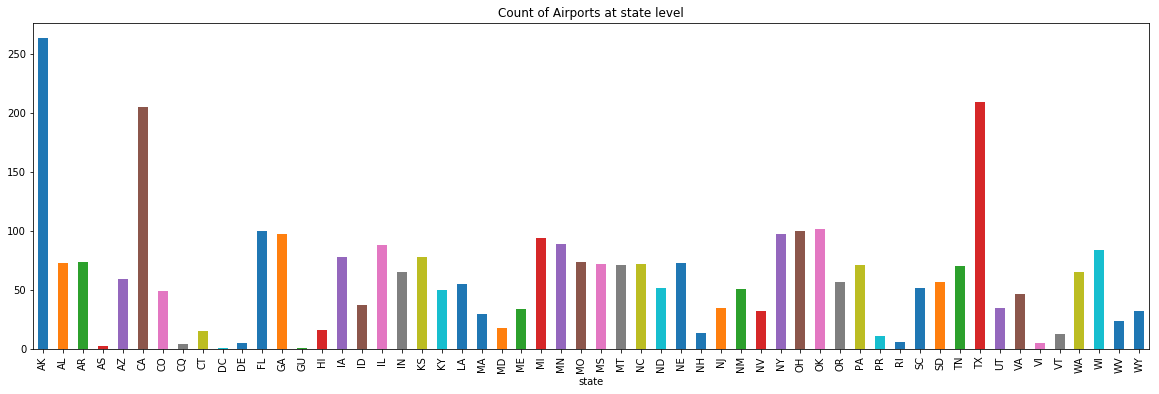

In [23]:
# Count of airports at state level
plt.figure(figsize=(20,6))
airport.groupby('state')['iata'].count().plot.bar(title='Count of Airports at state level')

In [24]:
# verify if all airport codes present in external data
display(len(set(data['Origin']).difference(set(airport['iata']))))
display(len(set(data['Dest']).difference(set(airport['iata']))))

3

5

In [25]:
## Getting details for source airport
data = pd.merge(data,airport[['iata','city','state','country','lat','long','no_airports']],how='left',left_on='Origin',right_on='iata')
display(data.head(2))
## Getting details for destination airport
data = pd.merge(data,airport[['iata','city','state','country','lat','long']],how='left',left_on='Dest',right_on='iata')
display(data.head(2))

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,flight_pre_post_count,hist_avg_delay_origin,holiday,weekend,extended_weekend,week_number,iata,city,state,country,lat,long,no_airports
0,2004,1,12,1,623.0,6,901.0,9,UA,462,N805UA,98.0,105,80.0,-14.0,-7.0,ORD,CLT,599,7,11,0,NaN,0,0,0,0,0,0,2004-01-12,41.0,35.61,0,0,1,2.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0
1,2004,1,13,2,621.0,6,911.0,9,UA,462,N851UA,110.0,105,78.0,-4.0,-9.0,ORD,CLT,599,16,16,0,NaN,0,0,0,0,0,0,2004-01-13,40.0,33.50,0,0,0,2.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,flight_pre_post_count,hist_avg_delay_origin,holiday,weekend,extended_weekend,week_number,iata_x,city_x,state_x,country_x,lat_x,long_x,no_airports,iata_y,city_y,state_y,country_y,lat_y,long_y
0,2004,1,12,1,623.0,6,901.0,9,UA,462,N805UA,98.0,105,80.0,-14.0,-7.0,ORD,CLT,599,7,11,0,NaN,0,0,0,0,0,0,2004-01-12,41.0,35.61,0,0,1,2.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0,CLT,Charlotte,NC,USA,35.214011,-80.943126
1,2004,1,13,2,621.0,6,911.0,9,UA,462,N851UA,110.0,105,78.0,-4.0,-9.0,ORD,CLT,599,16,16,0,NaN,0,0,0,0,0,0,2004-01-13,40.0,33.50,0,0,0,2.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0,CLT,Charlotte,NC,USA,35.214011,-80.943126


In [26]:
pd.isnull(data[['lat_x','lat_y']]).sum()

lat_x    4651
lat_y    4650
dtype: int64

In [27]:
# if we drop here, not a significant number of loss in rows
data.dropna(subset=['lat_x','lat_y'],inplace=True)
display(data.shape)

(7102719, 49)

Distance is given in data but it may or may not be actual distance. let say if flight get diverted, distance will not be actual one.  

In [28]:
# calculate actual distance b/w origin airport and destination airport
data['actual_distance'] = data[['lat_x','lat_y','long_x','long_y']].apply(get_actual_distance,axis=1)

In [29]:
# check if any other country than USA
display(data['country_x'].unique())
display(data['country_y'].unique())

array(['USA'], dtype=object)

array(['USA'], dtype=object)

In [30]:
#check if source and destination state same
display((data['state_x']==data['state_y']).value_counts(normalize=True))

data['same_state'] = data.apply(check_same_state,axis=1)
display(data['same_state'].value_counts(normalize=True))

False    0.868485
True     0.131515
dtype: float64

0    0.868485
1    0.131515
Name: same_state, dtype: float64

In [31]:
import gc
gc.collect()

14

Lets see count of Airports at State level (Origin and Destination wise). Idea is if count for some states is very very less, group those states together to reduce number of categorical variables.

In [160]:
# data.groupby(['state_x'])['Origin'].describe().reset_index()

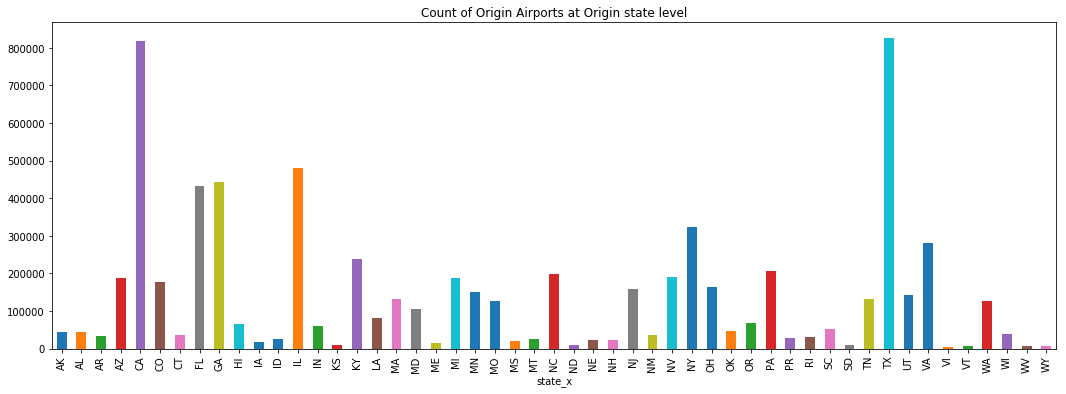

In [33]:
plt.figure(figsize=(18,6))
data.groupby('state_x')['Origin'].count().plot.bar(title='Count of Origin Airports at Origin state level')

From above graph, can see count of some state_x is very very less, can group together (KS,ND,SD,VI,VT,WY,WY). Rule: count<10k

In [161]:
# data.groupby(['state_y'])['Dest'].describe().reset_index()

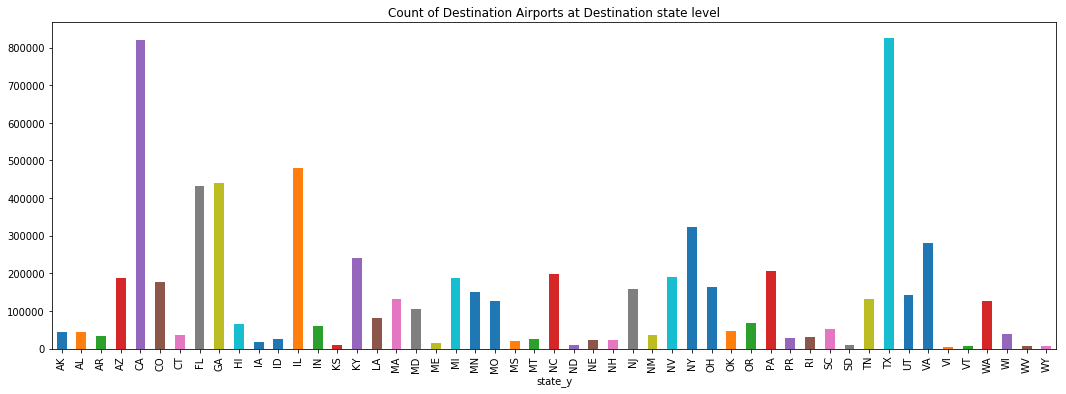

In [35]:
plt.figure(figsize=(18,6))
data.groupby('state_y')['Dest'].count().plot.bar(title='Count of Destination Airports at Destination state level')

From above graph, can see count of some state_y is very very less, can group together (ND,SD,VI,VT,WY,WY). Rule: count<10k

#### Carrier Level Feature (feature - 5)

##### Get percentage of flight for each carrier

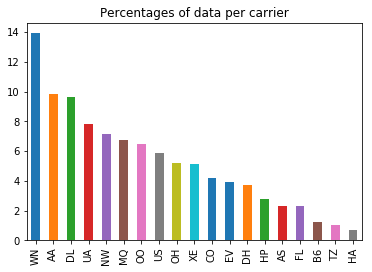

In [36]:
(data['UniqueCarrier'].value_counts(normalize=True)*100).plot.bar(title='Percentages of data per carrier')

In [37]:
carrier_per = pd.DataFrame(data['UniqueCarrier'].value_counts(normalize=True)*100).\
                reset_index().rename(columns={'index':'UniqueCarrier','UniqueCarrier':'carrier_per'})

data = pd.merge(data,carrier_per,how='left',on='UniqueCarrier')
display(data.head())

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,flight_pre_post_count,hist_avg_delay_origin,holiday,weekend,extended_weekend,week_number,iata_x,city_x,state_x,country_x,lat_x,long_x,no_airports,iata_y,city_y,state_y,country_y,lat_y,long_y,actual_distance,same_state,carrier_per
0,2004,1,12,1,623.0,6,901.0,9,UA,462,N805UA,98.0,105,80.0,-14.0,-7.0,ORD,CLT,599,7,11,0,NaN,0,0,0,0,0,0,2004-01-12,41.0,35.61,0,0,1,2.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0,CLT,Charlotte,NC,USA,35.214011,-80.943126,964.643084,0,7.804856
1,2004,1,13,2,621.0,6,911.0,9,UA,462,N851UA,110.0,105,78.0,-4.0,-9.0,ORD,CLT,599,16,16,0,NaN,0,0,0,0,0,0,2004-01-13,40.0,33.50,0,0,0,2.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0,CLT,Charlotte,NC,USA,35.214011,-80.943126,964.643084,0,7.804856
2,2004,1,14,3,633.0,6,920.0,9,UA,462,N436UA,107.0,105,88.0,5.0,3.0,ORD,CLT,599,4,15,0,NaN,0,0,0,0,0,0,2004-01-14,40.0,30.77,0,0,0,2.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0,CLT,Charlotte,NC,USA,35.214011,-80.943126,964.643084,0,7.804856
3,2004,1,15,4,627.0,6,859.0,9,UA,462,N828UA,92.0,105,78.0,-16.0,-3.0,ORD,CLT,599,4,10,0,NaN,0,0,0,0,0,0,2004-01-15,41.0,29.31,0,0,0,3.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0,CLT,Charlotte,NC,USA,35.214011,-80.943126,964.643084,0,7.804856
4,2004,1,16,5,635.0,6,918.0,9,UA,462,N831UA,103.0,105,87.0,3.0,5.0,ORD,CLT,599,3,13,0,NaN,0,0,0,0,0,0,2004-01-16,40.0,27.96,0,0,1,3.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0,CLT,Charlotte,NC,USA,35.214011,-80.943126,964.643084,0,7.804856


##### Historical delay per carrier

In [38]:
gpby_col = ['UniqueCarrier','date']
## get average delay for each carrier at date level
date_avg_delay = data.groupby(by=gpby_col).agg({'ArrDelay':'mean'}).reset_index()
date_avg_delay = date_avg_delay.sort_values(by='date')
date_avg_delay.reset_index(inplace=True)
## get historical average delay for each carrier
date_avg_delay['hist_avg_delay_carrier'] = date_avg_delay.apply(hist_avg_delay, df=date_avg_delay\
                                                                ,col_name='UniqueCarrier',buffer_days=120,axis=1)
## Merge historical average delay at day, carrier level with complete data 
data = pd.merge(data,date_avg_delay[['UniqueCarrier','date','hist_avg_delay_carrier']],how='left',left_on = gpby_col,right_on=gpby_col)

#### Get external data for TailNum (Feature - 6)

In [39]:
# number of unique tail number
data['TailNum'].nunique()

5449

In [40]:
taildata = pd.read_csv('../input/plane-data.csv')
display(taildata.shape)
display(taildata.tail(3))

(5029, 9)

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
5026,N998DL,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992
5027,N999CA,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1998
5028,N999DN,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992


In [41]:
# verify if all tailnum present in external data
display(len(set(data['TailNum']).difference(set(taildata['tailnum']))))

1740

In [42]:
taildata.rename(columns={'year':'manufacture_year','tailnum':'TailNum'},inplace=True)
data = pd.merge(data,taildata[['TailNum','type','aircraft_type','engine_type','manufacture_year','status']],how='left',on='TailNum')

display(data.head(3))

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,flight_pre_post_count,hist_avg_delay_origin,holiday,weekend,extended_weekend,week_number,iata_x,city_x,state_x,country_x,lat_x,long_x,no_airports,iata_y,city_y,state_y,country_y,lat_y,long_y,actual_distance,same_state,carrier_per,hist_avg_delay_carrier,type,aircraft_type,engine_type,manufacture_year,status
0,2004,1,12,1,623.0,6,901.0,9,UA,462,N805UA,98.0,105,80.0,-14.0,-7.0,ORD,CLT,599,7,11,0,NaN,0,0,0,0,0,0,2004-01-12,41.0,35.61,0,0,1,2.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0,CLT,Charlotte,NC,USA,35.214011,-80.943126,964.643084,0,7.804856,21.55,Corporation,Fixed Wing Multi-Engine,Turbo-Jet,1998,Valid
1,2004,1,13,2,621.0,6,911.0,9,UA,462,N851UA,110.0,105,78.0,-4.0,-9.0,ORD,CLT,599,16,16,0,NaN,0,0,0,0,0,0,2004-01-13,40.0,33.50,0,0,0,2.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0,CLT,Charlotte,NC,USA,35.214011,-80.943126,964.643084,0,7.804856,20.07,Corporation,Fixed Wing Multi-Engine,Turbo-Jet,2002,Valid
2,2004,1,14,3,633.0,6,920.0,9,UA,462,N436UA,107.0,105,88.0,5.0,3.0,ORD,CLT,599,4,15,0,NaN,0,0,0,0,0,0,2004-01-14,40.0,30.77,0,0,0,2.0,ORD,Chicago,IL,USA,41.979595,-87.904464,88.0,CLT,Charlotte,NC,USA,35.214011,-80.943126,964.643084,0,7.804856,18.15,Corporation,Fixed Wing Multi-Engine,Turbo-Jet,1996,Valid


In [43]:
display(pd.isnull(data['manufacture_year']).sum()/data.shape[0])
display(pd.isnull(data['aircraft_type']).sum()/data.shape[0])
display(pd.isnull(data['engine_type']).sum()/data.shape[0])

0.36415533262684335

0.36415533262684335

0.36415533262684335

As we can see that 36% of data is NaN for manufacturer year after merging with tail data. So, better to drop taildata and TailNum column as well. Original Idea was to **calculate aircraft age** from using manufacture year.

In [44]:
data.drop(['TailNum','type','aircraft_type','engine_type','manufacture_year','status'],axis=1,inplace=True)

#### Check FlightNum

In [45]:
data['FlightNum'].nunique()

7706

Don't derive any features for flight as if we get new flight. should drop FlightNum as large number of unique values exist and will not be helpful for prediction

#### Variation in Arrival Delay at Month Level

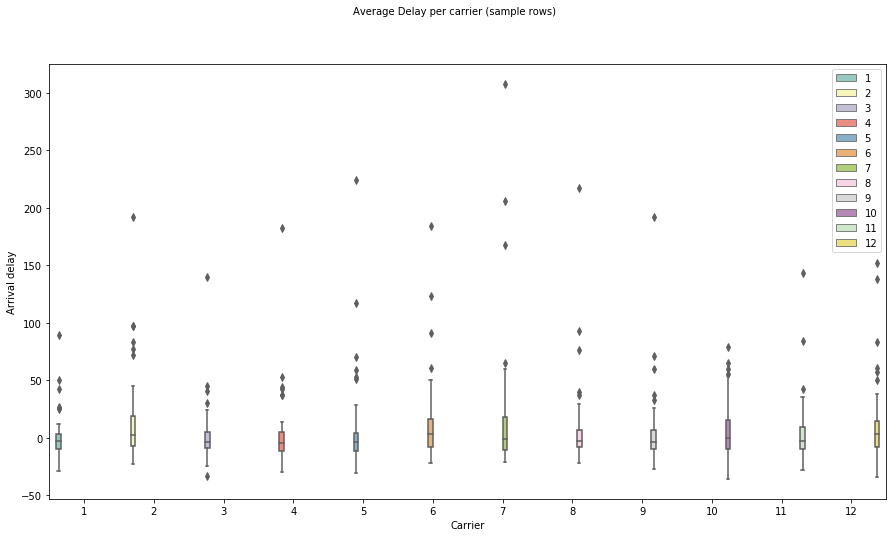

In [46]:
col_cat_analyse = 'Month'
col_val_analyse = 'ArrDelay'
# x = data[(data[col_cat_analyse]=='OO') | (data[col_cat_analyse]=='NW') | (data[col_cat_analyse]=='WN')]
df = data[[col_cat_analyse,col_val_analyse]].sample(frac=0.0001)
# sns.set(style="whitegrid")
f = plt.figure(figsize=(15,8))
ax = sns.boxplot(x=col_cat_analyse, y=col_val_analyse, data=df,palette="Set3",hue=col_cat_analyse)
f.suptitle('Average Delay per carrier (sample rows)', fontsize=10)
plt.xlabel('Carrier')
plt.ylabel('Arrival delay')
plt.legend(loc='upper right')

#### Variation in Arrival Delay at Day of week Level

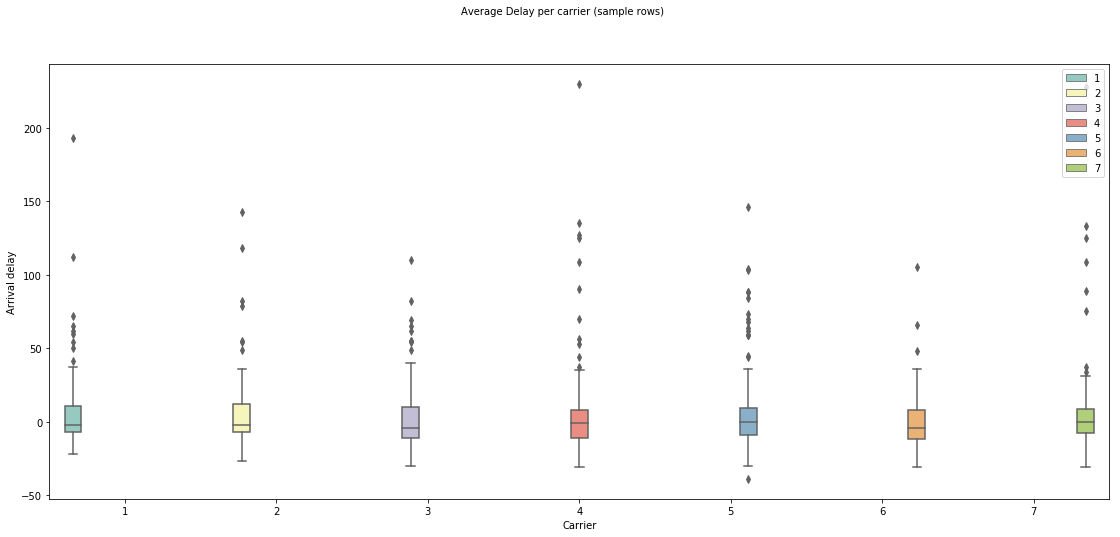

In [47]:
col_cat_analyse = 'DayOfWeek'
col_val_analyse = 'ArrDelay'
# x = data[(data[col_cat_analyse]=='OO') | (data[col_cat_analyse]=='NW') | (data[col_cat_analyse]=='WN')]
df = data[[col_cat_analyse,col_val_analyse]].sample(frac=0.0001)
# sns.set(style="whitegrid")
f = plt.figure(figsize=(19,8))
ax = sns.boxplot(x=col_cat_analyse, y=col_val_analyse, data=df,palette="Set3",hue=col_cat_analyse)
f.suptitle('Average Delay per carrier (sample rows)', fontsize=10)
plt.xlabel('Carrier')
plt.ylabel('Arrival delay')
plt.legend(loc='upper right')

#### Average Delay for sample carrier for sample rows

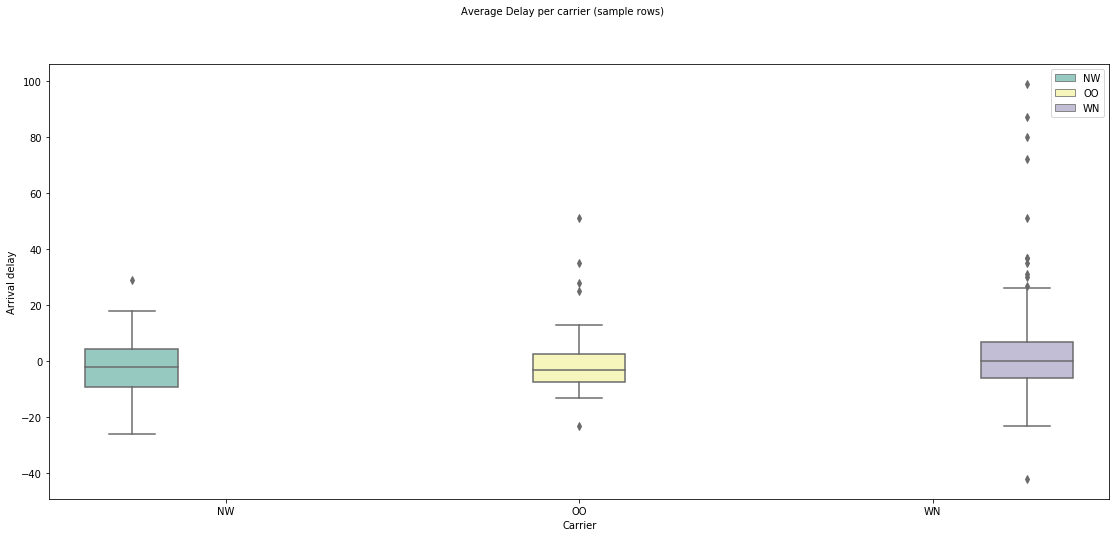

In [48]:
col_cat_analyse = 'UniqueCarrier'
col_val_analyse = 'ArrDelay'
x = data[(data[col_cat_analyse]=='OO') | (data[col_cat_analyse]=='NW') | (data[col_cat_analyse]=='WN')]
df = x[[col_cat_analyse,col_val_analyse]].sample(frac=0.0001)
# sns.set(style="whitegrid")
f = plt.figure(figsize=(19,8))
ax = sns.boxplot(x=col_cat_analyse, y=col_val_analyse, data=df,palette="Set3",hue=col_cat_analyse)
f.suptitle('Average Delay per carrier (sample rows)', fontsize=10)
plt.xlabel('Carrier')
plt.ylabel('Arrival delay')
plt.legend(loc='upper right')

#### Checking null values

In [49]:
check_null_values(data)

Year                            0
Month                           0
DayofMonth                      0
DayOfWeek                       0
DepTime                    127307
CRSDepTime                      0
ArrTime                    141035
CRSArrTime                      0
UniqueCarrier                   0
FlightNum                       0
ActualElapsedTime          141035
CRSElapsedTime                  0
AirTime                    141035
ArrDelay                   141035
DepDelay                   127307
Origin                          0
Dest                            0
Distance                        0
TaxiIn                          0
TaxiOut                         0
Cancelled                       0
CancellationCode          6975405
Diverted                        0
CarrierDelay                    0
WeatherDelay                    0
NASDelay                        0
SecurityDelay                   0
LateAircraftDelay               0
date                            0
flight_pre_pos

For column 'ArrDelay', missing values are 141541. Let's investigate the reason.

Get subset of data where flight is either cancelled or diverted. In both cases, flight will delay for sure and should have some value for 'ArrDelay'. 

In [50]:
# subset of data where flight is either cancelled or diverted
x = data[(data['Cancelled']==1) | (data['Diverted']==1)]

In [51]:
# check null values for that subset of data
check_null_values(x)

Year                           0
Month                          0
DayofMonth                     0
DayOfWeek                      0
DepTime                   127307
CRSDepTime                     0
ArrTime                   141035
CRSArrTime                     0
UniqueCarrier                  0
FlightNum                      0
ActualElapsedTime         141035
CRSElapsedTime                 0
AirTime                   141035
ArrDelay                  141035
DepDelay                  127307
Origin                         0
Dest                           0
Distance                       0
TaxiIn                         0
TaxiOut                        0
Cancelled                      0
CancellationCode           13728
Diverted                       0
CarrierDelay                   0
WeatherDelay                   0
NASDelay                       0
SecurityDelay                  0
LateAircraftDelay              0
date                           0
flight_pre_post_count          0
hist_avg_d

As we can see above, missing values for **ArrDelay** is still same i.e. 141541. It means that ArrDelay have NaN when flight is either cancelled or diverted. And we already know that ArrDelay contains continuous value where positive value indicate that flight get delayed. So, while **imputation** for ArrDelay, it is safe to impute its values by any positive number say 1 (for Goal -I) i.e. flights didn't arrive on time or simply delayed. 

**Caution**: Imputation actually depends on Goal as well i.e. Is it regression or classification? It will **not be correct** way if we impute ArrDelay by 1 and use it for regression. Better to discard NaN rows for regression as we already have sufficient number data points. 

In [52]:
# data['ArrDelay'].fillna(1,inplace=True)
data.dropna(subset=['ArrDelay'],inplace=True)

In [53]:
check_null_values(data)

Year                            0
Month                           0
DayofMonth                      0
DayOfWeek                       0
DepTime                         0
CRSDepTime                      0
ArrTime                         0
CRSArrTime                      0
UniqueCarrier                   0
FlightNum                       0
ActualElapsedTime               0
CRSElapsedTime                  0
AirTime                         0
ArrDelay                        0
DepDelay                        0
Origin                          0
Dest                            0
Distance                        0
TaxiIn                          0
TaxiOut                         0
Cancelled                       0
CancellationCode          6961677
Diverted                        0
CarrierDelay                    0
WeatherDelay                    0
NASDelay                        0
SecurityDelay                   0
LateAircraftDelay               0
date                            0
flight_pre_pos

##### Feature Selection

Now, need to **eliminate** columns that aren't relevant to a predictive model and then again check status of missing values.

Two types of feature can be removed:

    1) Type I feature: Features which are not useful for model. Example - TailNum, Year,
    2) Type II feature: Features which can not be captured at the time of flight booking. 
    Example - ArrTime, DepTime, ActualElapsedTime, CRSElapsedTime, AirTime,DepDelay,Distance, TaxiIn, TaxiOut, Cancelled, CancellationCode, Diverted, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay, 'ArrDelay'


However, feature 'ArrDelay' can not be removed from data as it will serve as output variable.

In [54]:
display(data.columns)

Index([u'Year', u'Month', u'DayofMonth', u'DayOfWeek', u'DepTime',
       u'CRSDepTime', u'ArrTime', u'CRSArrTime', u'UniqueCarrier',
       u'FlightNum', u'ActualElapsedTime', u'CRSElapsedTime', u'AirTime',
       u'ArrDelay', u'DepDelay', u'Origin', u'Dest', u'Distance', u'TaxiIn',
       u'TaxiOut', u'Cancelled', u'CancellationCode', u'Diverted',
       u'CarrierDelay', u'WeatherDelay', u'NASDelay', u'SecurityDelay',
       u'LateAircraftDelay', u'date', u'flight_pre_post_count',
       u'hist_avg_delay_origin', u'holiday', u'weekend', u'extended_weekend',
       u'week_number', u'iata_x', u'city_x', u'state_x', u'country_x',
       u'lat_x', u'long_x', u'no_airports', u'iata_y', u'city_y', u'state_y',
       u'country_y', u'lat_y', u'long_y', u'actual_distance', u'same_state',
       u'carrier_per', u'hist_avg_delay_carrier'],
      dtype='object')

In [55]:
col_to_remove = ['Year','DepTime','ArrTime','FlightNum','ActualElapsedTime', 'CRSElapsedTime', 'AirTime','DepDelay',\
'Origin', 'Dest','Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',\
'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','date','iata_x',\
                 'city_x','country_x', 'lat_x', 'long_x','iata_y', 'city_y','country_y',\
                'lat_y', 'long_y','DayofMonth']

remaining_cols = list(set(data.columns).difference(col_to_remove))

display(remaining_cols)

['CRSArrTime',
 'DayOfWeek',
 'extended_weekend',
 'weekend',
 'hist_avg_delay_carrier',
 'ArrDelay',
 'week_number',
 'holiday',
 'CRSDepTime',
 'UniqueCarrier',
 'actual_distance',
 'state_y',
 'state_x',
 'carrier_per',
 'hist_avg_delay_origin',
 'flight_pre_post_count',
 'Month',
 'same_state',
 'no_airports']

In [56]:
# get data with remaining columns only
data = data[remaining_cols]
display(data.shape)

(6961684, 19)

As you can see, we reduced number of columns from 29 (present in original data) to 13. 

In [57]:
# check null values again in filtered data
check_null_values(data)

CRSArrTime                    0
DayOfWeek                     0
extended_weekend              0
weekend                       0
hist_avg_delay_carrier    18345
ArrDelay                      0
week_number                   0
holiday                       0
CRSDepTime                    0
UniqueCarrier                 0
actual_distance               0
state_y                       0
state_x                       0
carrier_per                   0
hist_avg_delay_origin         0
flight_pre_post_count         0
Month                         0
same_state                    0
no_airports                   0
dtype: int64

In [58]:
# simply remove NaN as we already have large number of data points and facing resource issues. 
data.dropna(inplace=True)
check_null_values(data)

"Null values don't exist"

Cool !!. Null Values don't exist at all in data. Till Now, missing values have been replaced and the list of columns has been narrowed down to those most relevant to the model.

#### Create Data for both Goals

Goal I is classification problem, need to discretize ArrDelay. ArrDelay will have two values 0 and 1. 0 signifies flight arrived on time and 1 signifies flight delayed. To discretize, use **simple rule** i.e. replace ArrDelay by 1 where values greater than 15 else 0.

Goal II is reression problem, let ArrDelay as it is i.e. continuous. 

In [59]:
# create output variable for goal-I i.e. 0 or 1 using 15 minute rule.
data['ArrDelay_classification'] = (data['ArrDelay']>15).astype(int)
# rename ArrDelay for regression
data.rename(columns={'ArrDelay':'ArrDelay_regression'},inplace=True)

In [60]:
# def get_clean_data(input_file_path,dump_file_path):
#     gc.collect()
#     # filtering columns
#     remaining_cols = ['Month', 'Dest', 'ArrDelay', 'DayOfWeek',\
#                       'CRSArrTime', 'DayofMonth', 'Origin','CRSDepTime','FlightNum','UniqueCarrier']
#     # loading data
#     try:
#         data = pd.read_csv(input_file_path,usecols = remaining_cols)
#         gc.collect()
#     except Exception as e:
#         display("Loading Error: {}".format(e))
#         return
#     # dropping NaN rows
#     data.dropna(inplace=True)
#     # binning column - CRSDepTime, CRSArrTime
#     data['CRSDepTime'] = data['CRSDepTime']//100
#     data['CRSArrTime'] = data['CRSArrTime']//100
#     # handling special case of 2400 and 0000 hhmm
#     data['CRSArrTime'] = data['CRSArrTime'].replace({24:0})
#     # binning validation
#     assert data['CRSDepTime'].nunique()==24
#     assert data['CRSArrTime'].nunique()==24
#     # dummify categorical data
#     gc.collect()
#     #data = pd.get_dummies(data, columns=['Origin', 'Dest'])
#     #gc.collect()
#     # validation - drop of columns 'Origin','Dest'
#     #assert 'Dest' not in data.columns
#     #assert 'Origin' not in data.columns
#     # create output variable for goal-I i.e. 0 or 1 using 15 minute rule.
#     data['ArrDelay_classification'] = (data['ArrDelay']>15).astype(int)
#     # rename ArrDelay for regression
#     data.rename(columns={'ArrDelay':'ArrDelay_regression'},inplace=True)
#     # save data
#     try:
#         #data.to_csv(dump_file_path,index=False)
#         display("Data preparation and dump completes sucessfully")
#         return data
#     except Exception as e:
#         display("Dumping Error: {}".format(e))
#         return

In [61]:
# input_file_path = '../input/2004.csv'
# dump_file_path = '../input/2004_clean_data.csv'
# data = get_clean_data(input_file_path,dump_file_path)

In [62]:
display(data.shape)

(6943339, 20)

#### check distribution of Flight Delay

In [63]:
data['ArrDelay_classification'].value_counts(normalize=True)

0    0.805977
1    0.194023
Name: ArrDelay_classification, dtype: float64

## Step IV: Building  Model 

For this Notebook, to solve both goals can use any of below approach. We will go through both approach and compare the result.

**Approach 1:** 

Make Independent models for both goals. Difference will be on side of output variable only i.e. for Goal-I, output variable will be discrete (0 or 1) and for Goal-II, output variable will be continuous.

**Approach 2:**

Make only regression model and on top of its output apply 15 minute rule to simply classify in 0 or 1.

To **compare** the output from approach 1 and approach 2, both approach should have same dataset. So, we have dropped rows where ArrDelay is NaN.

#### Get training and test Data for both Goal-I and Goal-II

In [64]:
g1_y = data['ArrDelay_classification']
g2_y = data['ArrDelay_regression']
data.drop(['ArrDelay_classification','ArrDelay_regression'],axis=1,inplace=True)
# get goal-I data
g1_train_x, g1_test_x, g1_train_y, g1_test_y = train_test_split(data, g1_y, test_size=0.07,\
                                                                stratify=g1_y,random_state=42)

g1_train_x, g1_val_x, g1_train_y, g1_val_y = train_test_split(g1_train_x, g1_train_y, test_size=0.07,\
                                                                stratify=g1_train_y,random_state=42)

# get goal-II data
g2_train_x, g2_test_x, g2_train_y, g2_test_y = train_test_split(data, g2_y, test_size=0.07,\
                                                                random_state=42)

g2_train_x, g2_val_x, g2_train_y, g2_val_y = train_test_split(g2_train_x, g2_train_y, test_size=0.07,\
                                                                random_state=42)

display("Train data: {}".format(g1_train_x.shape))
display("Test data: {}".format(g1_test_x.shape))

'Train data: (6005293, 18)'

'Test data: (486034, 18)'

#### Approach - 1

###### Goal-I: classification Model

In [65]:
display(data.dtypes)

CRSArrTime                  int64
DayOfWeek                   int64
extended_weekend            int64
weekend                     int64
hist_avg_delay_carrier    float64
week_number               float64
holiday                     int64
CRSDepTime                  int64
UniqueCarrier              object
actual_distance           float64
state_y                    object
state_x                    object
carrier_per               float64
hist_avg_delay_origin     float64
flight_pre_post_count     float64
Month                       int64
same_state                  int64
no_airports               float64
dtype: object

In [66]:
col_to_object = ['CRSArrTime','DayOfWeek','extended_weekend','weekend',\
                 'holiday','CRSDepTime','UniqueCarrier','state_y','state_x','Month','same_state','week_number']

for col in col_to_object:
    g1_train_x[col] = g1_train_x[col].astype(str)
    g1_test_x[col] = g1_test_x[col].astype(str)
    g1_val_x[col] = g1_val_x[col].astype(str)

categorical_features_indices = np.where((g1_train_x.dtypes == 'object'))[0]
display(categorical_features_indices)

array([ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11, 15, 16])

In [67]:
## See No of unique values in each categorical variable
display(data[col_to_object].nunique())

CRSArrTime          24
DayOfWeek            7
extended_weekend     2
weekend              2
holiday              1
CRSDepTime          24
UniqueCarrier       19
state_y             51
state_x             51
Month               12
same_state           2
week_number          5
dtype: int64

In [68]:
clf=CatBoostClassifier(iterations = 400, depth = 5, learning_rate=0.045,loss_function='Logloss',use_best_model=True,
                     logging_level='Verbose',eval_metric = 'AUC')

In [69]:
history = clf.fit(g1_train_x, g1_train_y,cat_features=categorical_features_indices,eval_set=(g1_val_x,g1_val_y),plot=True)

CatboostIpythonWidget(layout=Layout(align_self=u'stretch', height=u'500px'))

0:	learn: 0.5661762	test: 0.5658888	best: 0.5658888 (0)	total: 5.93s	remaining: 39m 26s
1:	learn: 0.5698600	test: 0.5695943	best: 0.5695943 (1)	total: 11.8s	remaining: 39m 8s
2:	learn: 0.5706807	test: 0.5704742	best: 0.5704742 (2)	total: 17.5s	remaining: 38m 41s
3:	learn: 0.5710384	test: 0.5706310	best: 0.5706310 (3)	total: 22.9s	remaining: 37m 44s
4:	learn: 0.5718385	test: 0.5713081	best: 0.5713081 (4)	total: 28.4s	remaining: 37m 23s
5:	learn: 0.5990058	test: 0.5989742	best: 0.5989742 (5)	total: 34.2s	remaining: 37m 26s
6:	learn: 0.6147728	test: 0.6151099	best: 0.6151099 (6)	total: 39.1s	remaining: 36m 32s
7:	learn: 0.6215316	test: 0.6222747	best: 0.6222747 (7)	total: 44.5s	remaining: 36m 20s
8:	learn: 0.6292785	test: 0.6301857	best: 0.6301857 (8)	total: 49.3s	remaining: 35m 39s
9:	learn: 0.6331478	test: 0.6341088	best: 0.6341088 (9)	total: 53.6s	remaining: 34m 51s
10:	learn: 0.6362928	test: 0.6372318	best: 0.6372318 (10)	total: 58.9s	remaining: 34m 44s
11:	learn: 0.6385726	test: 0.63

91:	learn: 0.7285259	test: 0.7314472	best: 0.7314472 (91)	total: 8m 21s	remaining: 27m 58s
92:	learn: 0.7301697	test: 0.7331529	best: 0.7331529 (92)	total: 8m 27s	remaining: 27m 54s
93:	learn: 0.7314378	test: 0.7344206	best: 0.7344206 (93)	total: 8m 31s	remaining: 27m 46s
94:	learn: 0.7317043	test: 0.7347195	best: 0.7347195 (94)	total: 8m 37s	remaining: 27m 41s
95:	learn: 0.7318051	test: 0.7348141	best: 0.7348141 (95)	total: 8m 43s	remaining: 27m 37s
96:	learn: 0.7318854	test: 0.7348947	best: 0.7348947 (96)	total: 8m 48s	remaining: 27m 32s
97:	learn: 0.7331347	test: 0.7362047	best: 0.7362047 (97)	total: 8m 54s	remaining: 27m 27s
98:	learn: 0.7342120	test: 0.7373407	best: 0.7373407 (98)	total: 9m	remaining: 27m 22s
99:	learn: 0.7348771	test: 0.7380027	best: 0.7380027 (99)	total: 9m 4s	remaining: 27m 14s
100:	learn: 0.7349904	test: 0.7381248	best: 0.7381248 (100)	total: 9m 10s	remaining: 27m 10s
101:	learn: 0.7354691	test: 0.7386073	best: 0.7386073 (101)	total: 9m 16s	remaining: 27m 5s
1

179:	learn: 0.7559923	test: 0.7599710	best: 0.7599710 (179)	total: 16m 29s	remaining: 20m 9s
180:	learn: 0.7561388	test: 0.7601364	best: 0.7601364 (180)	total: 16m 35s	remaining: 20m 4s
181:	learn: 0.7563843	test: 0.7603886	best: 0.7603886 (181)	total: 16m 41s	remaining: 19m 59s
182:	learn: 0.7565078	test: 0.7605233	best: 0.7605233 (182)	total: 16m 46s	remaining: 19m 53s
183:	learn: 0.7566302	test: 0.7606710	best: 0.7606710 (183)	total: 16m 52s	remaining: 19m 48s
184:	learn: 0.7568668	test: 0.7609348	best: 0.7609348 (184)	total: 16m 57s	remaining: 19m 42s
185:	learn: 0.7570784	test: 0.7611722	best: 0.7611722 (185)	total: 17m 4s	remaining: 19m 38s
186:	learn: 0.7572251	test: 0.7613253	best: 0.7613253 (186)	total: 17m 9s	remaining: 19m 32s
187:	learn: 0.7573645	test: 0.7614711	best: 0.7614711 (187)	total: 17m 16s	remaining: 19m 28s
188:	learn: 0.7574889	test: 0.7616103	best: 0.7616103 (188)	total: 17m 22s	remaining: 19m 23s
189:	learn: 0.7575806	test: 0.7617189	best: 0.7617189 (189)	tota

267:	learn: 0.7643104	test: 0.7689693	best: 0.7689693 (267)	total: 25m 3s	remaining: 12m 20s
268:	learn: 0.7643664	test: 0.7690350	best: 0.7690350 (268)	total: 25m 10s	remaining: 12m 15s
269:	learn: 0.7644079	test: 0.7690810	best: 0.7690810 (269)	total: 25m 16s	remaining: 12m 10s
270:	learn: 0.7644425	test: 0.7691152	best: 0.7691152 (270)	total: 25m 22s	remaining: 12m 4s
271:	learn: 0.7644786	test: 0.7691561	best: 0.7691561 (271)	total: 25m 28s	remaining: 11m 59s
272:	learn: 0.7645223	test: 0.7691981	best: 0.7691981 (272)	total: 25m 34s	remaining: 11m 54s
273:	learn: 0.7645607	test: 0.7692389	best: 0.7692389 (273)	total: 25m 40s	remaining: 11m 48s
274:	learn: 0.7645985	test: 0.7692755	best: 0.7692755 (274)	total: 25m 45s	remaining: 11m 42s
275:	learn: 0.7646574	test: 0.7693501	best: 0.7693501 (275)	total: 25m 51s	remaining: 11m 37s
276:	learn: 0.7646915	test: 0.7693871	best: 0.7693871 (276)	total: 25m 58s	remaining: 11m 31s
277:	learn: 0.7647207	test: 0.7694184	best: 0.7694184 (277)	to

356:	learn: 0.7687410	test: 0.7738349	best: 0.7738349 (356)	total: 34m 12s	remaining: 4m 7s
357:	learn: 0.7687673	test: 0.7738657	best: 0.7738657 (357)	total: 34m 18s	remaining: 4m 1s
358:	learn: 0.7688276	test: 0.7739277	best: 0.7739277 (358)	total: 34m 24s	remaining: 3m 55s
359:	learn: 0.7688567	test: 0.7739571	best: 0.7739571 (359)	total: 34m 30s	remaining: 3m 50s
360:	learn: 0.7688728	test: 0.7739773	best: 0.7739773 (360)	total: 34m 36s	remaining: 3m 44s
361:	learn: 0.7688911	test: 0.7740065	best: 0.7740065 (361)	total: 34m 42s	remaining: 3m 38s
362:	learn: 0.7689219	test: 0.7740416	best: 0.7740416 (362)	total: 34m 48s	remaining: 3m 32s
363:	learn: 0.7689406	test: 0.7740641	best: 0.7740641 (363)	total: 34m 54s	remaining: 3m 27s
364:	learn: 0.7689654	test: 0.7740941	best: 0.7740941 (364)	total: 35m	remaining: 3m 21s
365:	learn: 0.7689976	test: 0.7741252	best: 0.7741252 (365)	total: 35m 6s	remaining: 3m 15s
366:	learn: 0.7690260	test: 0.7741534	best: 0.7741534 (366)	total: 35m 12s	re

In [70]:
g1_train_pred_prob = clf.predict_proba(g1_train_x)
g1_val_pred_prob = clf.predict_proba(g1_val_x)
g1_test_pred_prob = clf.predict_proba(g1_test_x)

In [71]:
display("Train Auc Score {}".format(roc_auc_score(g1_train_y, g1_train_pred_prob[:, 1])))
display("Val Auc Score {}".format(roc_auc_score(g1_val_y, g1_val_pred_prob[:, 1])))
display("Test Auc Score {}".format(roc_auc_score(g1_test_y, g1_test_pred_prob[:, 1])))

'Train Auc Score 0.782364716684'

'Val Auc Score 0.775114555374'

'Test Auc Score 0.7741901416'

Train, validation and test AUC score are quite similar i.e. very minute difference between there score. Good sign that model is **not overfitting**. 

#### Saving Model

In [101]:
clf.save_model('models/catboost_classification_v1')

#### Result Visualization

Text(0,0.5,u'True Positive Rate')

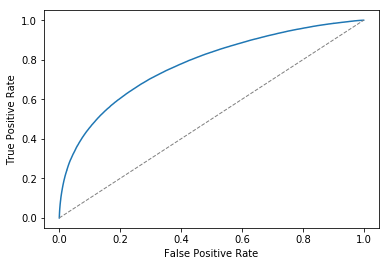

In [75]:
fpr, tpr, _ = roc_curve(g1_test_y, g1_test_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [90]:
g1_train_x.dtypes.index

Index([u'CRSArrTime', u'DayOfWeek', u'extended_weekend', u'weekend',
       u'hist_avg_delay_carrier', u'week_number', u'holiday', u'CRSDepTime',
       u'UniqueCarrier', u'actual_distance', u'state_y', u'state_x',
       u'carrier_per', u'hist_avg_delay_origin', u'flight_pre_post_count',
       u'Month', u'same_state', u'no_airports'],
      dtype='object')

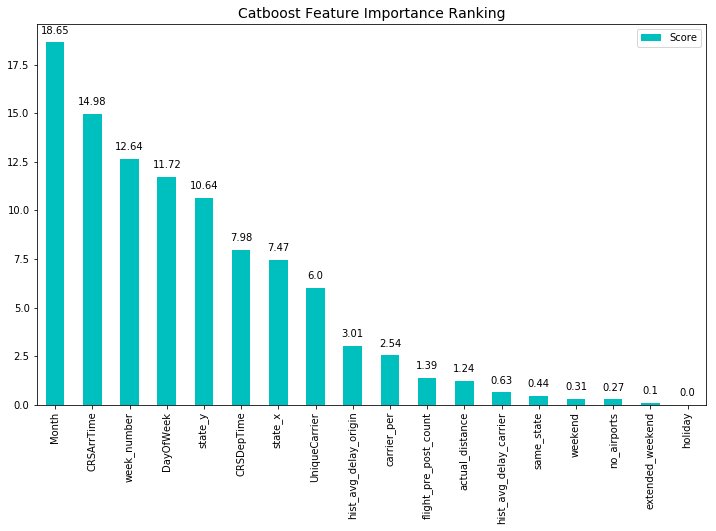

In [91]:
## code taken from KAGGLE (https://www.kaggle.com/mistrzuniu1/tutorial-eda-feature-selection-regression) ##
feature_score = pd.DataFrame(list(zip(g1_train_x.dtypes.index, clf.get_feature_importance(Pool(g1_train_x, label=g1_train_y,\
                cat_features=categorical_features_indices)))),columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

## visualize

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

###### Goal-II: Regression Model

In [127]:
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

# Copy data so that if any changes made to this data, not affect original data. 
tx2 = deepcopy(g2_train_x)
ty2 = deepcopy(g2_train_y)

vx2 = deepcopy(g2_val_x)
vy2 = deepcopy(g2_val_y)

tex2 = deepcopy(g2_test_x)
tey2 = deepcopy(g2_test_y)

In [129]:
# Assigning number to category
for c in col_to_object:
    lbl = LabelEncoder() 
    lbl.fit(list(tx2[c].values)) 
    tx2[c] = lbl.transform(list(tx2[c].values))
    vx2[c] = lbl.transform(list(vx2[c].values))
    tex2[c] = lbl.transform(list(tex2[c].values))

##### LinearRegression

In [139]:
lr = LinearRegression()
lr.fit(tx2,ty2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [142]:
display("Train MAPE Score {}".format(mean_absolute_error(ty2, lr.predict(tx2))))
display("Val MAPE Score {}".format(mean_absolute_error(vy2,lr.predict(vx2))))
display("Test MAPE Score {}".format(mean_absolute_error(tey2, lr.predict(tex2))))

'Train MAPE Score 18.6695950608'

'Val MAPE Score 18.6974982959'

'Test MAPE Score 18.6831791897'

In [154]:
display("Train R2 Score {}".format(r2_score(ty2, lr.predict(tx2))))
display("Val R2 Score {}".format(r2_score(vy2,lr.predict(vx2))))
display("Test R2 Score {}".format(r2_score(tey2, lr.predict(tex2))))

'Train R2 Score 0.0272384618476'

'Val R2 Score 0.02771416463'

'Test R2 Score 0.0281386481945'

#### Lasso, Elastic, Ridge

In [155]:
model_elastic = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005))
model_ridge = Ridge(alpha = 5)
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005))

In [156]:
model_lasso.fit(tx2,ty2)

model_elastic.fit(tx2,ty2)
model_ridge.fit(tx2,ty2)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

#### LASSO Evaluation

In [158]:
display("Train MAPE Score {}".format(mean_absolute_error(ty2, model_lasso.predict(tx2))))
display("Val MAPE Score {}".format(mean_absolute_error(vy2,model_lasso.predict(vx2))))
display("Test MAPE Score {}".format(mean_absolute_error(tey2, model_lasso.predict(tex2))))

'Train MAPE Score 18.6694699686'

'Val MAPE Score 18.6973639001'

'Test MAPE Score 18.6830608022'

##### Ridge Evaluation

In [152]:
display("Train MAPE Score {}".format(mean_absolute_error(ty2, model_ridge.predict(tx2))))
display("Val MAPE Score {}".format(mean_absolute_error(vy2,model_ridge.predict(vx2))))
display("Test MAPE Score {}".format(mean_absolute_error(tey2, model_ridge.predict(tex2))))

'Train MAPE Score 18.669594947'

'Val MAPE Score 18.697498164'

'Test MAPE Score 18.6831790854'

#### CatboostRegressor

In [76]:
bestparams = { 'depth': 4,
 'iterations': 400,
 'l2_leaf_reg': 3,
 'learning_rate': 0.2,
 'thread_count': 4,
 'loss_function': 'RMSE'}

In [110]:
# bestparams = { 'depth': 4,
#               'l2_leaf_reg':4,
#  'iterations': 400,
#  'learning_rate': 0.15,
#  'loss_function': 'RMSE','border_count':15}

In [111]:
model=CatBoostRegressor(**bestparams)
history = model.fit(g2_train_x,g2_train_y,cat_features=categorical_features_indices,eval_set=(g2_val_x,g2_val_y),plot=True)

CatboostIpythonWidget(layout=Layout(align_self=u'stretch', height=u'500px'))

0:	learn: 33.7844462	test: 33.8538085	best: 33.8538085 (0)	total: 3.72s	remaining: 24m 42s
1:	learn: 33.6552121	test: 33.7237267	best: 33.7237267 (1)	total: 5.43s	remaining: 18m 1s
2:	learn: 33.5396986	test: 33.6066326	best: 33.6066326 (2)	total: 7.32s	remaining: 16m 8s
3:	learn: 33.4342730	test: 33.4994474	best: 33.4994474 (3)	total: 10.2s	remaining: 16m 49s
4:	learn: 33.3324467	test: 33.3967489	best: 33.3967489 (4)	total: 11.4s	remaining: 15m 4s
5:	learn: 33.2449931	test: 33.3078460	best: 33.3078460 (5)	total: 13.2s	remaining: 14m 26s
6:	learn: 33.1654382	test: 33.2269508	best: 33.2269508 (6)	total: 16.4s	remaining: 15m 19s
7:	learn: 33.0910170	test: 33.1516367	best: 33.1516367 (7)	total: 18.1s	remaining: 14m 45s
8:	learn: 33.0333540	test: 33.0922314	best: 33.0922314 (8)	total: 20.1s	remaining: 14m 31s
9:	learn: 32.9699074	test: 33.0272093	best: 33.0272093 (9)	total: 22.1s	remaining: 14m 20s
10:	learn: 32.9103922	test: 32.9669804	best: 32.9669804 (10)	total: 23.8s	remaining: 14m
11:	

89:	learn: 31.3937998	test: 31.3992662	best: 31.3992662 (89)	total: 3m 45s	remaining: 12m 57s
90:	learn: 31.3788190	test: 31.3832332	best: 31.3832332 (90)	total: 3m 48s	remaining: 12m 55s
91:	learn: 31.3652501	test: 31.3686369	best: 31.3686369 (91)	total: 3m 50s	remaining: 12m 53s
92:	learn: 31.3525472	test: 31.3555459	best: 31.3555459 (92)	total: 3m 52s	remaining: 12m 47s
93:	learn: 31.3484331	test: 31.3510294	best: 31.3510294 (93)	total: 3m 55s	remaining: 12m 46s
94:	learn: 31.3436641	test: 31.3457543	best: 31.3457543 (94)	total: 3m 57s	remaining: 12m 43s
95:	learn: 31.3413858	test: 31.3434135	best: 31.3434135 (95)	total: 4m	remaining: 12m 42s
96:	learn: 31.3295739	test: 31.3309882	best: 31.3309882 (96)	total: 4m 3s	remaining: 12m 41s
97:	learn: 31.3117317	test: 31.3119635	best: 31.3119635 (97)	total: 4m 5s	remaining: 12m 36s
98:	learn: 31.3009509	test: 31.3004398	best: 31.3004398 (98)	total: 4m 7s	remaining: 12m 33s
99:	learn: 31.2911473	test: 31.2895914	best: 31.2895914 (99)	total:

176:	learn: 30.6286388	test: 30.5788797	best: 30.5788797 (176)	total: 7m 3s	remaining: 8m 53s
177:	learn: 30.6260084	test: 30.5765132	best: 30.5765132 (177)	total: 7m 6s	remaining: 8m 51s
178:	learn: 30.6246491	test: 30.5751511	best: 30.5751511 (178)	total: 7m 8s	remaining: 8m 48s
179:	learn: 30.6229778	test: 30.5731620	best: 30.5731620 (179)	total: 7m 10s	remaining: 8m 45s
180:	learn: 30.6213216	test: 30.5714986	best: 30.5714986 (180)	total: 7m 12s	remaining: 8m 43s
181:	learn: 30.6198633	test: 30.5698673	best: 30.5698673 (181)	total: 7m 15s	remaining: 8m 41s
182:	learn: 30.6185559	test: 30.5686699	best: 30.5686699 (182)	total: 7m 17s	remaining: 8m 38s
183:	learn: 30.6173491	test: 30.5674565	best: 30.5674565 (183)	total: 7m 19s	remaining: 8m 35s
184:	learn: 30.6162416	test: 30.5664509	best: 30.5664509 (184)	total: 7m 22s	remaining: 8m 34s
185:	learn: 30.6130600	test: 30.5629726	best: 30.5629726 (185)	total: 7m 25s	remaining: 8m 32s
186:	learn: 30.6064338	test: 30.5558388	best: 30.5558

263:	learn: 30.4069997	test: 30.3404181	best: 30.3404181 (263)	total: 10m 57s	remaining: 5m 38s
264:	learn: 30.4023571	test: 30.3351370	best: 30.3351370 (264)	total: 10m 59s	remaining: 5m 36s
265:	learn: 30.4012665	test: 30.3339509	best: 30.3339509 (265)	total: 11m 2s	remaining: 5m 33s
266:	learn: 30.3927018	test: 30.3244494	best: 30.3244494 (266)	total: 11m 5s	remaining: 5m 31s
267:	learn: 30.3917436	test: 30.3233665	best: 30.3233665 (267)	total: 11m 7s	remaining: 5m 28s
268:	learn: 30.3880787	test: 30.3194038	best: 30.3194038 (268)	total: 11m 10s	remaining: 5m 26s
269:	learn: 30.3871256	test: 30.3183949	best: 30.3183949 (269)	total: 11m 13s	remaining: 5m 24s
270:	learn: 30.3831491	test: 30.3140412	best: 30.3140412 (270)	total: 11m 16s	remaining: 5m 21s
271:	learn: 30.3820853	test: 30.3130216	best: 30.3130216 (271)	total: 11m 19s	remaining: 5m 19s
272:	learn: 30.3812620	test: 30.3121524	best: 30.3121524 (272)	total: 11m 22s	remaining: 5m 17s
273:	learn: 30.3795507	test: 30.3102358	bes

349:	learn: 30.2514056	test: 30.1701839	best: 30.1701839 (349)	total: 14m 58s	remaining: 2m 8s
350:	learn: 30.2507204	test: 30.1695080	best: 30.1695080 (350)	total: 15m 1s	remaining: 2m 5s
351:	learn: 30.2499604	test: 30.1687987	best: 30.1687987 (351)	total: 15m 4s	remaining: 2m 3s
352:	learn: 30.2486363	test: 30.1673603	best: 30.1673603 (352)	total: 15m 7s	remaining: 2m
353:	learn: 30.2476404	test: 30.1661377	best: 30.1661377 (353)	total: 15m 10s	remaining: 1m 58s
354:	learn: 30.2469011	test: 30.1655430	best: 30.1655430 (354)	total: 15m 12s	remaining: 1m 55s
355:	learn: 30.2465202	test: 30.1651240	best: 30.1651240 (355)	total: 15m 14s	remaining: 1m 53s
356:	learn: 30.2459295	test: 30.1644623	best: 30.1644623 (356)	total: 15m 17s	remaining: 1m 50s
357:	learn: 30.2455390	test: 30.1641519	best: 30.1641519 (357)	total: 15m 19s	remaining: 1m 47s
358:	learn: 30.2449365	test: 30.1634113	best: 30.1634113 (358)	total: 15m 22s	remaining: 1m 45s
359:	learn: 30.2440391	test: 30.1624086	best: 30.1

In [112]:
g2_train_pred_value = model.predict(g2_train_x)
g2_val_pred_value = model.predict(g2_val_x)
g2_test_pred_value = model.predict(g2_test_x)

##### CatboostEvaluation

In [113]:
display("Train RMSE Score {}".format(np.sqrt(mean_squared_error(g2_train_y, g2_train_pred_value))))
display("Val RMSE Score {}".format(np.sqrt(mean_squared_error(g2_val_y, g2_val_pred_value))))
display("Test RMSE Score {}".format(np.sqrt(mean_squared_error(g2_test_y, g2_test_pred_value))))

'Train RMSE Score 30.000554246'

'Val RMSE Score 30.1091561128'

'Test RMSE Score 29.908065353'

In [116]:
display("Train MAPE Score {}".format(mean_absolute_error(g2_train_y, g2_train_pred_value)))
display("Val MAPE Score {}".format(mean_absolute_error(g2_val_y, g2_val_pred_value)))
display("Test MAPE Score {}".format(mean_absolute_error(g2_test_y, g2_test_pred_value)))

'Train MAPE Score 16.3926841379'

'Val MAPE Score 16.4927641764'

'Test MAPE Score 16.4839121478'

#### Features Visualization

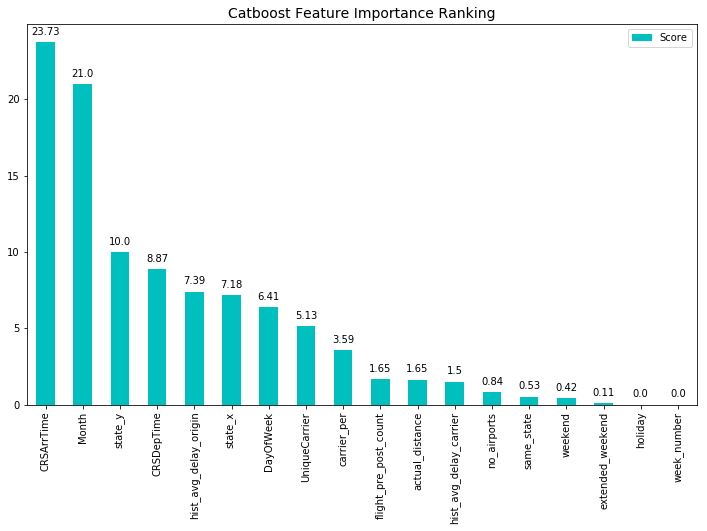

In [114]:
## code taken from KAGGLE (https://www.kaggle.com/mistrzuniu1/tutorial-eda-feature-selection-regression) ##
feature_score = pd.DataFrame(list(zip(g2_train_x.dtypes.index, clf.get_feature_importance(Pool(g2_train_x, label=g2_train_y,\
                cat_features=categorical_features_indices)))),columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

## visualize

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

#### Approach - 2

As Regression model not working fine, drop idea of using this approach.

## Step V : Future Scope

**External Dataset**
- **Aircraft** dataset can scrapped using TailNum feature [1]
- **Weather** dataset can also be one of important feature
- **Airport level** dataset in terms of number of runways, capacity of airport can be helpful
- Data for **city** of source airport like population, city status (Business city) can also be helpful
- **Festival calendar** data at region level can also be helpful 
****
**Feature Engineering**
- Some **magic features** like ratio of airport capacity and city's population can also be helpful
- Output variable in Goal-I i.e delay or not can be more categorized into small delay, large delay
- High level feature on departure time like 'early morning','morning','afternoon','evening','night' can be created
- High level feature on states **region** wise Like East, west
- **Mean encoding** of Categorical variables with smoothing can also be important where categorical values are large in 
number like state (source and destination airport) 
- Binning of less occurence of values for some categorical variable can be done like for some states in column source 
state and destination state
- Window/Buffer days can be adjusted while calculating historical level feature
- Flight direct or connecting
- Machine learning model should know that a feature is cyclical like Dayofweek, departure tome in hour format [2] 
- Removing Bias from dataset like some delays are unpredictable like delay due to accidient
- More features can be derived on  flights delay per airline and per airport level
****
**Modelling**
- Code can be more formalised (more of functions/class than free form)
- Experiment on approach for creation of dataset (training, validation and test set) for modelling can be performed like on time basis (out of time validation)
- Cross validation technique while model taining and prediction can also be used
- Hyperparameter Tuning can also be performed but as of now hardware resource (less computation power) is constraint.
- Ensemble, Stacking techniques can also be experimented to improve results.

1) https://www.flightradar24.com/data/aircraft/ + {each tail no}


2) https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes 